In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, avg, count, stddev, hour, dayofweek, when, percentile_approx, lit, rand, randn
from pyspark.sql.types import *

spark = SparkSession.builder \
        .appName("Traffic Analysis") \
        .master("local[*]") \
        .getOrCreate()

In [2]:


# Define schema with data types
schema = StructType([
    StructField("Longitude", DecimalType(10, 6), True),
    StructField("Latitude", DecimalType(10, 6), True),
    StructField("Battery %", DecimalType(5, 2), True),
    StructField("Speed", DecimalType(6, 2), True),
    StructField("Tracking Date", TimestampType(), True),
    StructField("vehicle_id", IntegerType(), True)
])

In [3]:
source_df = spark.read.option("header", "true").schema(schema).csv('gps-data.csv')

In [4]:
source_df.printSchema()

root
 |-- Longitude: decimal(10,6) (nullable = true)
 |-- Latitude: decimal(10,6) (nullable = true)
 |-- Battery %: decimal(5,2) (nullable = true)
 |-- Speed: decimal(6,2) (nullable = true)
 |-- Tracking Date: timestamp (nullable = true)
 |-- vehicle_id: integer (nullable = true)



In [5]:
source_df.count()

499

In [6]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
import random
#source_df = source_df.withColumn("vehicle_id", (F.rand() * 100).cast("int") + 1)

In [7]:
source_df.show()

+---------+---------+---------+-----+-------------------+----------+
|Longitude| Latitude|Battery %|Speed|      Tracking Date|vehicle_id|
+---------+---------+---------+-----+-------------------+----------+
|73.195000|18.467308|    63.64|43.71|2014-08-16 00:06:14|        74|
|73.106701|18.881745|    63.64|43.71|2014-08-15 23:50:27|        44|
|73.117135|18.904635|    60.00|43.71|2014-08-16 12:23:12|        39|
|73.124855|18.920570|    60.00|43.71|2014-08-16 12:04:58|        79|
|73.127135|18.930148|    61.82|43.71|2014-08-15 23:32:34|        21|
|73.117075|18.976493|    58.18|43.71|2014-08-16 13:28:28|        53|
|73.102210|19.021171|    63.64|43.71|2014-08-15 23:17:20|        73|
|73.093853|19.026613|    60.00|43.71|2014-08-16 13:46:14|        78|
|73.019203|19.053196|    59.09|43.71|2014-08-16 14:01:59|        95|
|72.935658|19.053301|    64.55|43.71|2014-08-15 22:43:08|        44|
|72.980203|19.064306|    59.09|43.71|2014-08-16 14:19:09|        49|
|73.012145|19.067915|    64.55|43.

In [8]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, avg, count, stddev, hour, dayofweek, when, percentile_approx
from pyspark.sql.types import StringType
#import geohash as gh

# Define geohash UDF
def simple_geohash(lat, lon, precision=3):
    """Create a simple geohash by rounding coordinates"""
    if lat is None or lon is None:
        return None
    return f"{round(lat, precision)}_{round(lon, precision)}"

# Register UDF
geohash_udf = F.udf(simple_geohash, StringType())


# 1. Geospatial aggregation
traffic_patterns = source_df \
    .withColumn("geohash", geohash_udf(col("latitude"), col("longitude"))) \
    .withColumn("hour", hour(col("tracking date"))) \
    .withColumn("day_of_week", dayofweek(col("tracking date"))) \
    .groupBy("geohash", "hour", "day_of_week") \
    .agg(
        avg("speed").alias("avg_speed"),
        count("vehicle_id").alias("vehicle_count"),
        stddev("speed").alias("speed_variance"),
        percentile_approx("speed", 0.5).alias("median_speed")
    ) \
    .withColumn("congestion_level", 
               when(col("avg_speed") < 10, "HIGH")
               .when(col("avg_speed") < 25, "MEDIUM")
               .otherwise("LOW"))


In [9]:

# Display results
traffic_patterns.show(20, truncate=False)
print(f"Total traffic pattern records: {traffic_patterns.count()}")


+-------------+----+-----------+---------+-------------+--------------+------------+----------------+
|geohash      |hour|day_of_week|avg_speed|vehicle_count|speed_variance|median_speed|congestion_level|
+-------------+----+-----------+---------+-------------+--------------+------------+----------------+
|18.405_72.817|18  |4          |26.780000|1            |NULL          |26.78       |LOW             |
|18.406_73.111|13  |7          |5.150000 |1            |NULL          |5.15        |HIGH            |
|18.408_72.856|12  |3          |36.910000|1            |NULL          |36.91       |LOW             |
|18.409_73.102|23  |5          |46.240000|1            |NULL          |46.24       |LOW             |
|18.412_73.195|21  |4          |22.380000|1            |NULL          |22.38       |MEDIUM          |
|18.417_73.019|6   |6          |20.120000|1            |NULL          |20.12       |MEDIUM          |
|18.418_73.032|15  |6          |8.850000 |1            |NULL          |8.85       

In [10]:
# Show congestion distribution
traffic_patterns.groupBy("congestion_level").count().show()

+----------------+-----+
|congestion_level|count|
+----------------+-----+
|            HIGH|   78|
|             LOW|  263|
|          MEDIUM|  158|
+----------------+-----+



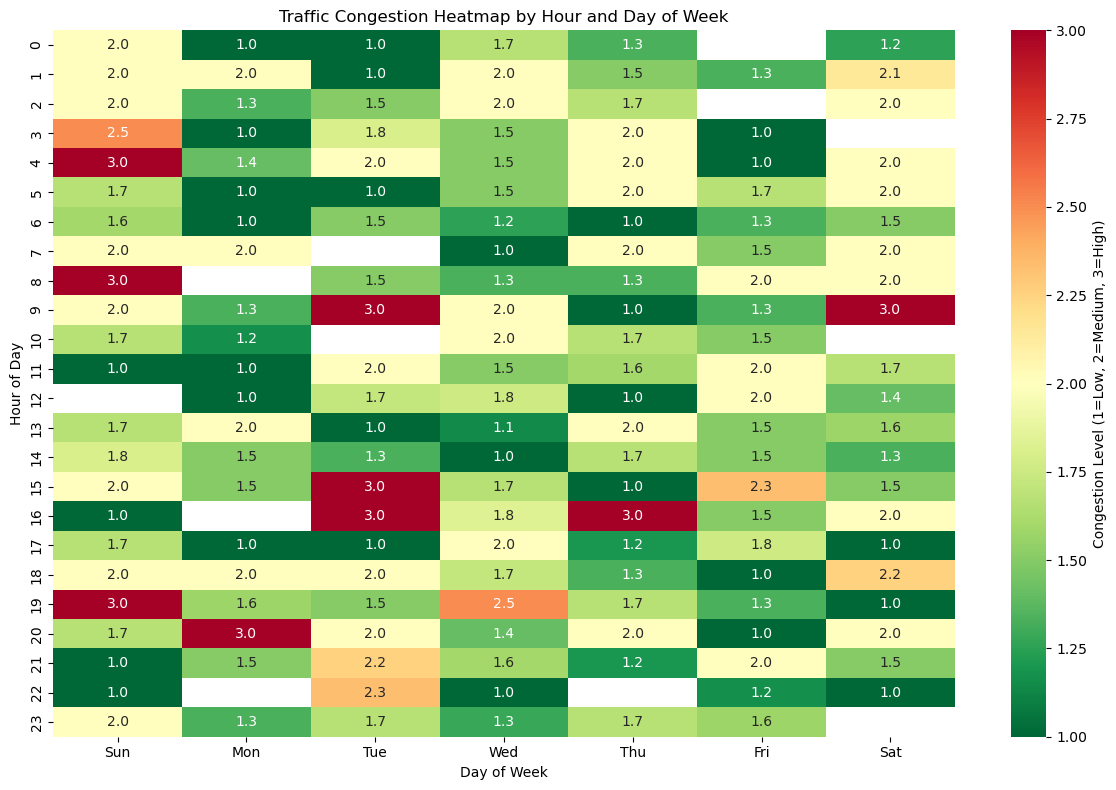

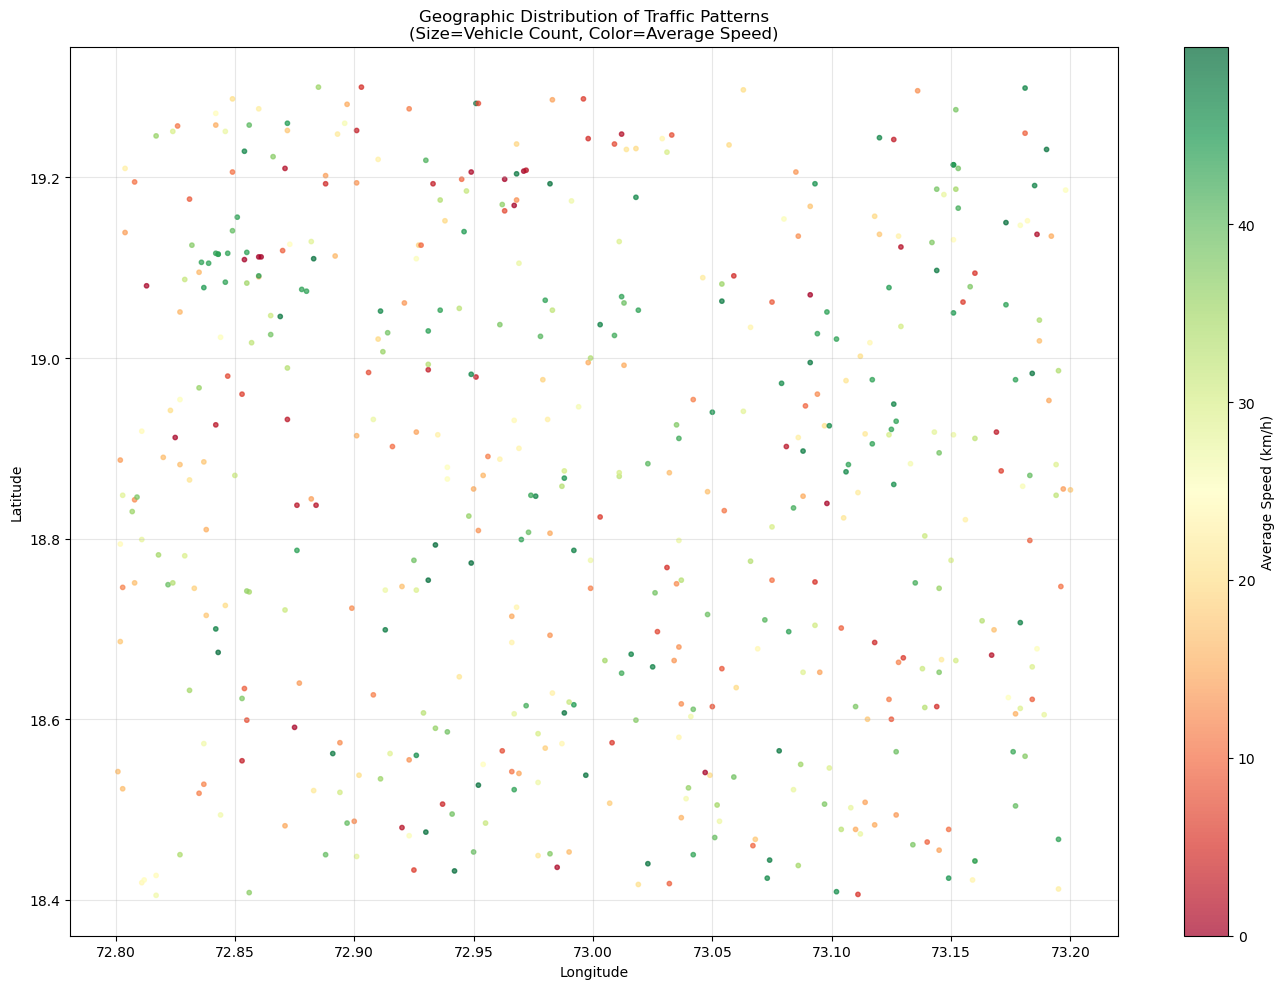

Traffic Pattern Summary:
Total geohash areas: 496
Peak hour (most vehicles): 18
Peak day: 4
Average speed across all areas: 26.22 km/h


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Convert traffic patterns to Pandas for visualization
traffic_pd = traffic_patterns.toPandas()

# Create heatmap by hour and day of week
#plt.figure(figsize=(12, 8))

# Prepare data for heatmap - average vehicle count by hour and day
#heatmap_data = traffic_pd.groupby(['hour', 'day_of_week'])['vehicle_count'].mean().reset_index()
#heatmap_pivot = heatmap_data.pivot(index='hour', columns='day_of_week', values='vehicle_count')

# Create heatmap
#sns.heatmap(heatmap_pivot, 
#            annot=True, 
#            fmt='.1f',
#            cmap='YlOrRd',
#            cbar_kws={'label': 'Average Vehicle Count'},
#            xticklabels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],
#            yticklabels=range(24))

#plt.title('Traffic Patterns Heatmap: Average Vehicle Count by Hour and Day of Week')
#plt.xlabel('Day of Week')
#plt.ylabel('Hour of Day')
#plt.tight_layout()
#plt.show()

# Create congestion level heatmap
plt.figure(figsize=(12, 8))

# Convert congestion level to numeric for heatmap
congestion_map = {'LOW': 1, 'MEDIUM': 2, 'HIGH': 3}
traffic_pd['congestion_numeric'] = traffic_pd['congestion_level'].map(congestion_map)

congestion_data = traffic_pd.groupby(['hour', 'day_of_week'])['congestion_numeric'].mean().reset_index()
congestion_pivot = congestion_data.pivot(index='hour', columns='day_of_week', values='congestion_numeric')

sns.heatmap(congestion_pivot, 
            annot=True, 
            fmt='.1f',
            cmap='RdYlGn_r',
            cbar_kws={'label': 'Congestion Level (1=Low, 2=Medium, 3=High)'},
            xticklabels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],
            yticklabels=range(24))

plt.title('Traffic Congestion Heatmap by Hour and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.tight_layout()
plt.show()

# Geographic heatmap of average speed by location
plt.figure(figsize=(14, 10))

# Extract lat/lon from geohash for geographic visualization
def decode_simple_geohash(geohash_str):
    if pd.isna(geohash_str):
        return None, None
    try:
        lat_str, lon_str = geohash_str.split('_')
        return float(lat_str), float(lon_str)
    except:
        return None, None

traffic_pd[['lat_decoded', 'lon_decoded']] = traffic_pd['geohash'].apply(
    lambda x: pd.Series(decode_simple_geohash(x))
)

# Create scatter plot with speed as color
valid_coords = traffic_pd.dropna(subset=['lat_decoded', 'lon_decoded'])

plt.scatter(valid_coords['lon_decoded'], 
           valid_coords['lat_decoded'], 
           c=valid_coords['avg_speed'], 
           cmap='RdYlGn', 
           s=valid_coords['vehicle_count']*10, 
           alpha=0.7)

plt.colorbar(label='Average Speed (km/h)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Traffic Patterns\n(Size=Vehicle Count, Color=Average Speed)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print("Traffic Pattern Summary:")
print(f"Total geohash areas: {traffic_pd['geohash'].nunique()}")
print(f"Peak hour (most vehicles): {traffic_pd.loc[traffic_pd['vehicle_count'].idxmax(), 'hour']}")
print(f"Peak day: {traffic_pd.loc[traffic_pd['vehicle_count'].idxmax(), 'day_of_week']}")
print(f"Average speed across all areas: {traffic_pd['avg_speed'].mean():.2f} km/h")